In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import jax.nn as nn
import equinox as eqx
import jax_dataloader as jdl

from tqdm import tqdm
import typing as tp
import pandas as pd
import math

import sys

import optax
import numpyro.distributions as D

from diffcv.mcmc.base import Sampler
from diffcv.mcmc.langevin import ULASampler, MALASampler
from diffcv.cv.nn import CVMLP, init_linear, normal_init
from diffcv.cv.training import CVTrainer, CVALSTrainer
from diffcv.cv.loss import DiffusionLoss, DiffLoss, VarLoss
from diffcv.logger import Logger, plot_log_results
from diffcv.cv.data import get_data_from_sampler
from diffcv.cv.utils import recu, requ
from diffcv.cv.generator import ScalarGenerator, VectorGenerator
from diffcv.mcmc.estimator import Estimator

sns.set_style("darkgrid")

In [3]:
DIST_DIM = 10 # Dimension of a Gaussian

SAMPLER_N_SAMPLES = 1000 # Number of samples in one chain
SAMPLER_N_BURNIN = 1000 # Number of samples to ignore in one chain

N_CHAINS = 100 # Number of parallel chains for MCMC estimates
MCMC_N_ESTIMATES = 1000 # Number of MCMC estimates to calculate CI

BATCH_SIZE = 256 # Batch size for CV training
TRAIN_SIZE = 5 * SAMPLER_N_SAMPLES
EVAL_SIZE = 20 * SAMPLER_N_SAMPLES

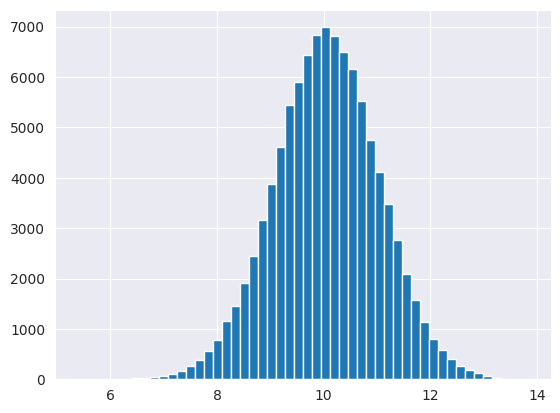

In [5]:
rng = jax.random.PRNGKey(50)

dist = D.MultivariateNormal(loc=10 * jnp.ones((DIST_DIM), dtype=float), covariance_matrix=jnp.eye((DIST_DIM), dtype=float))
log_prob = jax.jit(dist.log_prob)
grad_log_prob = jax.jit(jax.grad(dist.log_prob))

fn = jax.jit(lambda x: (x ** 2).sum(axis=-1))
true_pi = (dist.mean ** 2).sum() + dist.variance.sum()

sampler = MALASampler(
    log_prob=log_prob, 
    dim=DIST_DIM, 
    n_samples=SAMPLER_N_SAMPLES, 
    gamma=5e-2, 
    burnin_steps=SAMPLER_N_BURNIN, 
    init_std=3.0
)
rng, key = jax.random.split(rng)
samples = sampler(key, n_chains=N_CHAINS).reshape(-1, DIST_DIM)

plt.hist(samples[:, 0], bins=50)
plt.show()

In [6]:
class ModelWithConstant(eqx.Module):
    model: eqx.Module
    c: jax.Array
    
    def __init__(self, model: eqx.Module, shape, key: jax.random.PRNGKey):
        self.model = model
        self.c = jax.random.normal(key, shape)
    
    @eqx.filter_jit
    def __call__(self, x):
        return self.model(x)

In [11]:
def train_model(
        key: jax.random.PRNGKey, 
        dist_dim: int, 
        fn: tp.Callable, 
        grad_log_prob: tp.Callable,
        train_dataloader: jdl.DataLoader, 
        eval_dataloader: jdl.DataLoader,
        lr: float=1e-3, 
        loss_fn: str="diffusion", 
        optim: str="sgd",
        n_steps: int=30_000, 
        fn_mean: float | None=None, 
        patience: int=1000, 
        eval_every_n_steps: int=10_000,
        *,
        logger: Logger
    ):
    key, subkey = jax.random.split(key)
    model = CVMLP(in_size=dist_dim, depth=0, width_size=0, activation=jax.nn.elu, key=subkey)

    # rng, key = jax.random.split(rng)
    # model = init_linear(model, key, normal_init)

    scheduler = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    if optim == "sgd":
        optimizer = optax.inject_hyperparams(optax.sgd)(learning_rate=scheduler)
    elif optim == "adam":
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
    else:
        raise NotImplementedError(f"unknown optimizer: {optim}")
    
    if loss_fn == "diffusion":
        loss = DiffusionLoss(fn=fn)
    elif loss_fn == "diff":
        loss = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)
    elif loss_fn == "var":
        rng, key = jax.random.split(rng)
        model = ModelWithConstant(model, (1,), key)
        loss = VarLoss(fn=fn, grad_log_prob=grad_log_prob)
    else:
        raise NotImplementedError(f"unknown loss function: {loss_fn}")

    trainer = CVTrainer(
        model, 
        fn, 
        grad_log_prob, 
        train_dataloader,
        eval_dataloader,
        optimizer, 
        loss, 
        logger,
        fn_mean=fn_mean,
        n_steps=n_steps, 
        eval_every_n_steps=eval_every_n_steps,
        patience=patience,
    )

    key, subkey = jax.random.split(key)
    model = trainer.train(subkey)
    
    return model

def train_als_model(
        key: jax.random.PRNGKey, 
        dist_dim: int, 
        fn: tp.Callable, 
        grad_log_prob: tp.Callable,
        train_dataloader: jdl.DataLoader, 
        eval_dataloader: jdl.DataLoader,
        lr: float=1e-3, 
        n_steps: int=30_000, 
        switch_steps: int=10_000, 
        patience: int=1000, 
        eval_every_n_steps: int=10_000,
        *,
        logger: Logger
    ):

    key, subkey = jax.random.split(key)
    model = CVMLP(in_size=dist_dim, depth=0, width_size=0, activation=jax.nn.elu, key=subkey)

    # rng, key = jax.random.split(rng)
    # model = init_linear(model, key, normal_init)

    scheduler_diffusion = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    optimizer_diffusion = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler_diffusion)
    
    scheduler_stein = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    optimizer_stein = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler_stein)
    
    loss_diffusion = DiffusionLoss(fn=fn, l2_alpha=0.0)
    loss_stein = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)

    trainer = CVALSTrainer(
        model, 
        fn, 
        grad_log_prob, 
        train_dataloader,
        eval_dataloader,
        optimizer_diffusion, 
        optimizer_stein,
        loss_diffusion, 
        loss_stein,
        logger=logger, 
        switch_steps=switch_steps,
        n_steps=n_steps, 
        eval_every_n_steps=eval_every_n_steps,
        patience=patience,
    )

    key, subkey = jax.random.split(key)
    model = trainer.train(subkey)
    
    return model

In [8]:
rng, key = jax.random.split(rng)
base_estimates = Estimator(fn, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)
print("base:", Estimator.bias(true_pi, base_estimates), Estimator.std(base_estimates))

  0%|          | 0/1000 [00:00<?, ?it/s]

base: -0.015686035 1.2255646


train_dataset length: 5000
eval_dataset length: 20000


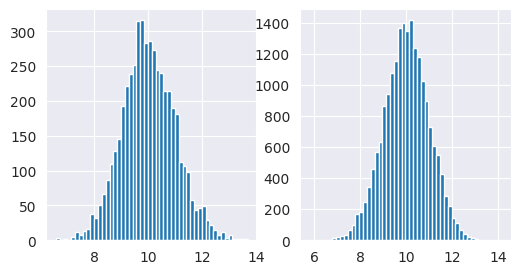

In [9]:
rng, key = jax.random.split(rng)
train_dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=TRAIN_SIZE // SAMPLER_N_SAMPLES)
print(f"train_dataset length: {len(train_dataloader.dataloader.dataset)}")

rng, key = jax.random.split(rng)
eval_dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=EVAL_SIZE // SAMPLER_N_SAMPLES)
print(f"eval_dataset length: {len(eval_dataloader.dataloader.dataset)}")

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataloader.dataloader.dataset[:, 0], bins=50)
plt.subplot(1, 2, 2)
plt.hist(eval_dataloader.dataloader.dataset[:, 0], bins=50)
plt.show()

In [12]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-3, 
    loss_fn="diffusion", 
    optim="adam", 
    n_steps=30_000, 
    fn_mean=base_estimates.mean(),
    patience=3000, 
    logger=logger
)

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("diffusion:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dataset length: 5000


  0%|          | 0/120000 [00:00<?, ?it/s]

train fn_mean:  1013.228
train fn_mean:  1009.475
train fn_mean:  1009.051
train fn_mean:  1008.794
train fn_mean:  1008.581
Early stopping at step 104551 due to no improvement in stein loss over 40000 steps.


  0%|          | 0/1000 [00:00<?, ?it/s]

diffusion als: 0.024780273 0.43055677


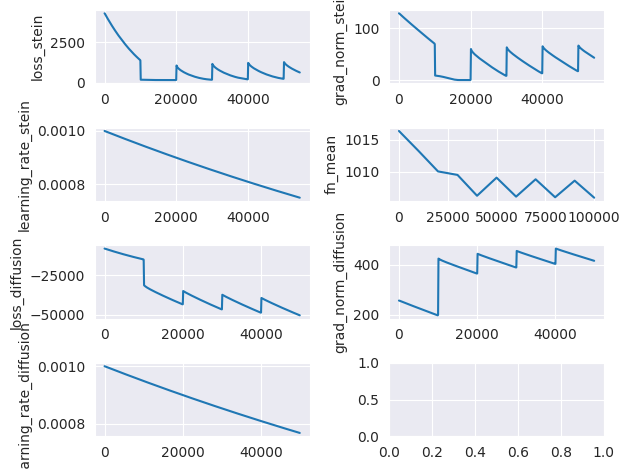

In [11]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_als_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-3, 
    n_steps=120_000, 
    switch_steps=10_000, 
    patience=40_000, 
    eval_every_n_steps=10_000, 
    logger=logger
)

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("diffusion als:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

dataset length: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

Early stopping at step 25022 due to no improvement in loss over 1000 steps.


c:\Users\kirill-korolev\mcmc-control-variates\diffcv\logger\logger.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

stein diff: -6.1035156e-05 0.07384293


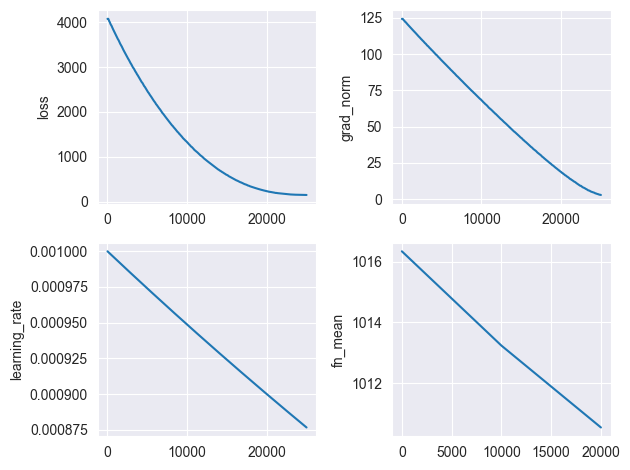

In [11]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-3, 
    loss_fn="diff", 
    optim="adam", 
    n_steps=30_000, 
    fn_mean=None,
    patience=3000, 
    logger=logger
)

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("stein diff:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

dataset length: 5000


  0%|          | 0/200000 [00:00<?, ?it/s]

Early stopping at step 152691 due to no improvement in loss over 1000 steps.
learned constant: [1010.185]


c:\Users\kirill-korolev\mcmc-control-variates\diffcv\logger\logger.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

var min: 0.0029296875 0.06332483


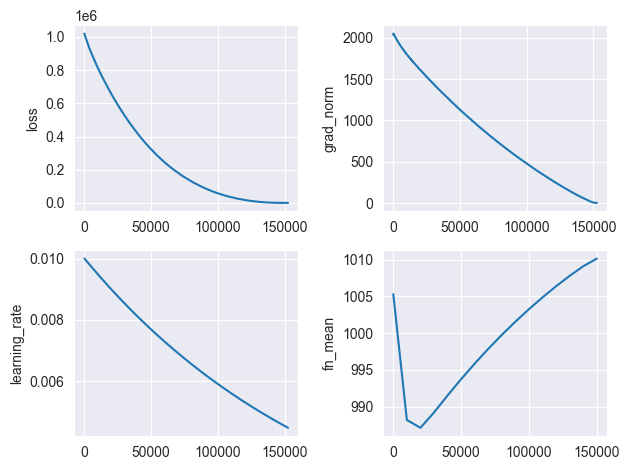

In [12]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-3, 
    loss_fn="var", 
    optim="adam", 
    n_steps=200_000, 
    fn_mean=None,
    patience=3000, 
    logger=logger
)

print(f"learned constant: {model.c}")
model = model.model

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("var min:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

In [ ]:
def base_run(dist_dim: int):
    rng = jax.random.PRNGKey(50)

    dist = D.MultivariateNormal(loc=10 * jnp.ones((dist_dim), dtype=float), covariance_matrix=jnp.eye((dist_dim), dtype=float))
    grad_log_prob = jax.jit(jax.grad(dist.log_prob))

    fn = jax.jit(lambda x: (x ** 2).sum(axis=-1))
    true_pi = (dist.mean ** 2).sum() + dist.variance.sum()

    sampler = ULASampler(grad_log_prob=grad_log_prob, dim=dist_dim, n_samples=1000, gamma=5e-2, burnin_steps=500, init_std=5.0)
    
    rng, key = jax.random.split(rng)
    base_estimates = Estimator(fn, sampler)(key, n_chains=100, n_estimates=1000)
    bias, std = Estimator.bias(true_pi, base_estimates), Estimator.std(base_estimates)
    print(dist_dim, bias, std)
    return bias, std

def diff_run(dist_dim: int):
    rng = jax.random.PRNGKey(50)

    dist = D.MultivariateNormal(loc=10 * jnp.ones((dist_dim), dtype=float), covariance_matrix=jnp.eye((dist_dim), dtype=float))
    grad_log_prob = jax.jit(jax.grad(dist.log_prob))

    fn = jax.jit(lambda x: (x ** 2).sum(axis=-1))
    true_pi = (dist.mean ** 2).sum() + dist.variance.sum()

    sampler = ULASampler(grad_log_prob=grad_log_prob, dim=dist_dim, n_samples=1000, gamma=5e-2, burnin_steps=500, init_std=5.0)
    
    logger = Logger()

    rng, key = jax.random.split(rng)
    model = train_model(
        key, batch_size=5000, sampler=sampler, dist_dim=dist_dim, fn=fn, grad_log_prob=grad_log_prob, loss_fn="diff", optim="adam",
        lr=1e-3, l2_alpha=0.0, n_steps=30_000, n_chains=5, logger=logger
    )

    #plot_log_results(logger)

    generator = ScalarGenerator(grad_log_prob, model)
    fn_with_cv = lambda x: fn(x) + generator(x)

    rng, key = jax.random.split(rng)
    diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=100, n_estimates=1000)

    bias = Estimator.bias(true_pi, diffusion_estimates)
    std = Estimator.std(diffusion_estimates)
    print(dist_dim, bias, std)
    
    return bias, std

In [ ]:
dims = [10, 100, 500, 1000]
base_biases = []
base_stds = []
for d in [10, 100, 500, 1000]:
    bias, std = base_run(d)
    base_biases.append(bias)
    base_stds.append(std)

  0%|          | 0/1000 [00:00<?, ?it/s]

base: -0.21490479 1.2299054


  0%|          | 0/1000 [00:00<?, ?it/s]

base: -2.5654297 3.981188


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
dims = [10, 100, 500, 1000]
biases = []
stds = []
for d in [10, 100, 500, 1000]:
    bias, std = diff_run(d)
    biases.append(bias)
    stds.append(std)

2024-08-08 16:42:09.664296: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


dataset length: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

10 -0.25543213 0.06658695
dataset length: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100 -2.5585938 0.35828072
dataset length: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

500 -12.714844 2.6905034
dataset length: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

KeyboardInterrupt: 